# Part 1: Downloading data

For this section we will be using the podaac data subscriber package in a python virtual env on tempest to download some beta pre validated SWOT data.

## Step 1: Open a command line interface on tempest. 

By now you should have a verified podaac data subscriber account.

Then we will create a python venv on tempest using the following code

Select your directory

    cd path/to/your/project
    
Check the directory

    pwd
    
Create the env change the env_name to what you want.

    python -m env_name venv
    
activate the environment

    source env_name/bin/activate
    
install the only package we will be using in this env

    pip install podaac-data-subscriber
    
You should now see a new folder in your current directory with the name of your new env. 

## Step 2: Create a .netrc file. 
This will need to be in your home directory, for example:

    /home/b91g481/.netrc
    
Create this .netric as a text file with the format:

machine urs.earthdata.nasa.gov
    login user_name
    password ***********

and nothing else. Save with the name as only '.netrc'

Once you have created the .netrc you will need to change the permissions of it in the shell with the command:

    chmod 600 ~/.netrc

## Step 3: Download and explore the data

Finally we will download the data and open the .ipynb and do our analysis with the following line of code. 

You will need to change some things so watch out! Also make sure that your virtual environment is active.

    podaac-data-downloader -c SWOT_L2_HR_Raster_1.1 -d path/to/output/location --start-date yyyy-mm-ddThh:mm:ssZ --end-date yyyy-mm-ddThh:mm:ssZ -b= "(coords for a bounding box goes here)"


# Challenge #1!

Using the command above, replace the path to where you want your output, the start date, the end date, and the coords for a bounding box and get the command to run properly and download valid SWOT data. I recomend searching the internet to find where/when/how to get these dates and locations. Copy and paste the line of code that you used below


podaac-data-downloader -c SWOT_L2_HR_Raster_1.1 -d C:\Thesis_Data\SWOT_data\Podaac_downloader --start-date 2023-04-07T23:00:00Z --end-date 2023-04-08T00:00:00Z -b="-180,-90,180,90"

# Part 2: Read in the data into python

In [1]:
import numpy as np
import matplotlib.pyplot as plt
import rasterio
import xarray as xr
import rioxarray as rio
import zipfile

## Tip 1
Find the path to the data you want to explore and enter it below

In [2]:
nc_file = xr.open_dataset('data/SWOT_L2_HR_Raster_250m_UTM55V_N_x_x_x_484_004_024F_20230407T230919_20230407T230940_PIB0_01.nc')
nc_file

<xarray.Dataset>
Dimensions:                  (x: 671, y: 671)
Coordinates:
  * x                        (x) float64 3.59e+05 3.592e+05 ... 5.265e+05
  * y                        (y) float64 6.583e+06 6.583e+06 ... 6.75e+06
Data variables: (12/39)
    crs                      object ...
    longitude                (y, x) float64 ...
    latitude                 (y, x) float64 ...
    wse                      (y, x) float32 ...
    wse_qual                 (y, x) float32 ...
    wse_qual_bitwise         (y, x) float64 ...
    ...                       ...
    load_tide_fes            (y, x) float32 ...
    load_tide_got            (y, x) float32 ...
    pole_tide                (y, x) float32 ...
    model_dry_tropo_cor      (y, x) float32 ...
    model_wet_tropo_cor      (y, x) float32 ...
    iono_cor_gim_ka          (y, x) float32 ...
Attributes: (12/49)
    Conventions:                   CF-1.7
    title:                         Level 2 KaRIn High Rate Raster Data Product
    source:                        Ka-band radar interferometer
    history:                       2023-09-15T13:41:15Z : Creation
    platform:                      SWOT
    reference_document:            JPL D-56416 - Revision B - October 24, 2022
    ...                            ...
    x_max:                         526500.0
    y_min:                         6582750.0
    y_max:                         6750250.0
    institution:                   JPL
    references:                    V1.0
    product_version:               01

This code cell will take the water surface elevation (WSE) measured by SWOT and write it out as a .tiff

## Tip 2
Using the output from the code above, find the correct epsg code to replace below. Also make sure you name your .tiff something useful in the last line



In [3]:
# firgue out the epsg of the data above
crs = 'epsg:32655'

#here we select out the wse data
wse = nc_file['wse']

#Change the epsg
wse.rio.write_crs(crs, inplace=True)

#set the x and y dims
wse = wse.rio.set_spatial_dims(x_dim='x', y_dim = 'y')

#I ran into an error trying to write to a .tiff that required me to delete the following attribute
del wse.attrs['grid_mapping']

#Write wse as a .tiff
wse.rio.to_raster("data/name_your_tif.tif")

# Challenge #2:

The next code block will make a simple plot of the WSE data. Go through a couple until you find one that seems to have good coverage. Upload the .tiff into ArcGIS pro (or something similar) and extract a single SWORD reach that covers many of the WSE pixels. This analysis requires both the .tif that we downloaded, and a SWORD reach that intersects a bunch of pixels of that WSE raster.

You can try loading different .nc files in and running the lines of code above to explore different WSE tifs to find one that is suitable. Maybe look for paths in the pixels that resemble a river.

You will be graded based on the next 3 plots that we will generate.

Link to SWORD network: 

http://gaia.geosci.unc.edu/SWORD/

Good luck!

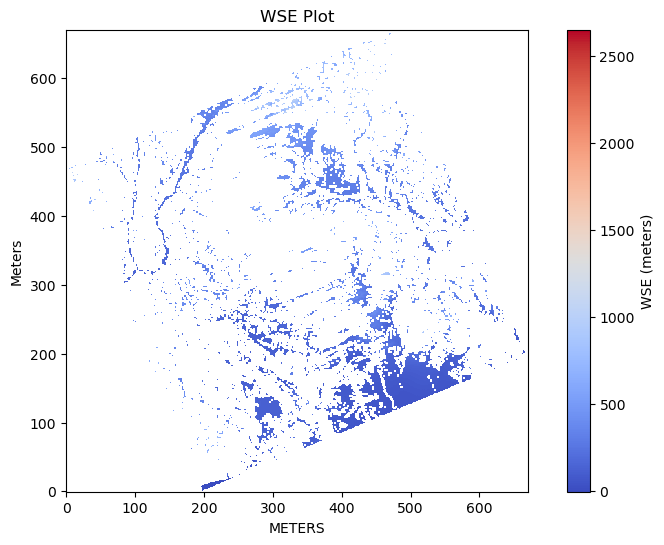

In [4]:
#Quick plot to see the data
plt.figure(figsize=(10, 6))
plt.imshow(wse, cmap='coolwarm', origin='lower')
plt.colorbar(label='WSE (meters)')
plt.title('WSE Plot')
plt.xlabel('METERS')
plt.ylabel('Meters')
plt.show()

In [5]:
#close the files to get them out of memory
nc_file.close()
wse.close()

# Part 3: The synthetic data creation/analysis

You shouldn't have to write much code for this section. But you should pay close attention to what it is doing,
as there will be questions about it.

## Tip 3

the path to the sword reach should be just a single line that you should have extracted from a larger SWORD dataset.

In [6]:
import geopandas as gpd
river = gpd.read_file('data/as_sword_reach_hb35_v15_FID_10625_id_35602400241.shp')
wse_raster = rio.open_rasterio('data/name_your_tif.tif',masked = True)
print(f'vector data dataset crs is:', river.crs)
print(f'raster crs is:', wse_raster.rio.crs)


vector data dataset crs is: EPSG:4326
raster crs is: EPSG:32655


## Tip 4

It will be much easier to reproject just a single line than it would be to reproject an entire raster right?

<Axes: >

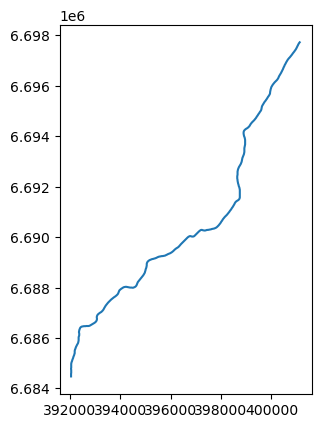

In [7]:
#Lets get them into the same CRS
river = river.to_crs('epsg:32655')
#quick plot to see it
river.plot()

<Axes: title={'center': 'band = 1, spatial_ref = 0'}, xlabel='x', ylabel='y'>

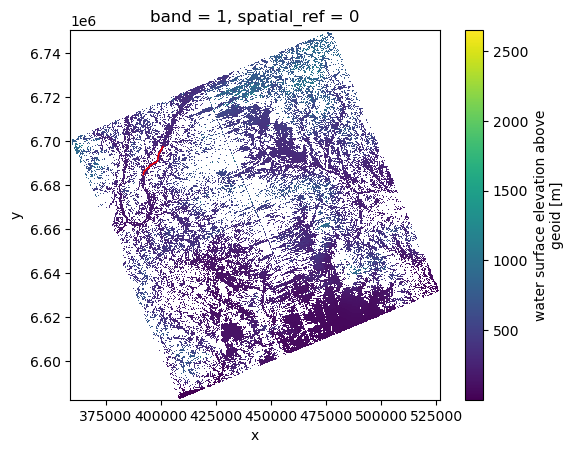

In [8]:
#This is a quick and dirty way to show only the pixels where the wse is > 0. 
band1 = wse_raster.sel(band=1)
masked_band1 = band1.where(band1 >= 0)

# Plot the masked data with the river section
masked_band1.plot()
river.plot(ax=plt.gca(), color='red', linewidth=1)

## Tip 5

If the reach and the raster above don't line up reasonably well, then go back and find two that do!

In [9]:
#first we will turn the river shape into a bunch of points, so that it simulates a bunch of GNSS data points
from shapely.geometry import MultiPoint

#The rest of this was developed with the help of chatGPT, thanks homie
# Function to interpolate points along a line
def interpolate_points(line, distance):
    num_points = int(line.length / distance)
    return MultiPoint([line.interpolate(i * distance) for i in range(num_points + 1)])

# Apply the function to each line in the GeoDataFrame, spacing is the spacing between points in meters.
spacing = 10
points_gdf = river.geometry.apply(lambda x: interpolate_points(x, spacing))

# Explode the MultiPoint objects into individual points
points_gdf = points_gdf.explode(index_parts=True).reset_index(drop=True)

# Create a new GeoDataFrame for the points
points_df = gpd.GeoDataFrame(geometry=points_gdf)

## Tip 6

what is the points_df, and what is the spacing of 10 doing exactly? Why do you think we need to do this?

    The points_df is basically just the SWORD reach that was a line, but as points spaced by 10 m.

<Axes: title={'center': 'band = 1, spatial_ref = 0'}, xlabel='x', ylabel='y'>

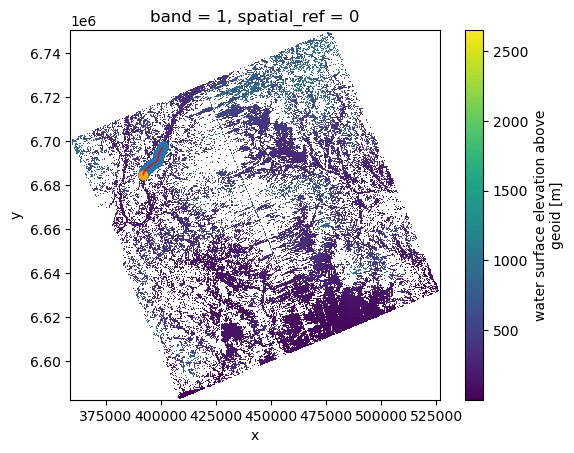

In [10]:
#plot everything together to make sure everything is in order

masked_band1.plot()
river.plot(ax=plt.gca(), color='red', linewidth=1)
points_df.plot(ax=plt.gca())
points_df.iloc[0:1].plot(ax=plt.gca(), color = 'orange')

## Tip 7
What exactly is differenct from the plot before and this one?

    This one includes all the points that we generated from the original SWORD line.

In [11]:
#First we pull the x and y of geometry of the points that we created. 
x = points_df.geometry.x
y = points_df.geometry.y

#then we select the values from the raster using those points 
wse_points = [wse_raster.sel(x = i, y = j, method = 'nearest') for (i,j) in zip(x,y)]

# I know this is probably inefficient, but hey, it works!
wse_list = []
for i in range(len(wse_points)):
    wse_list.append(wse_points[i].data[0])


In [12]:
#Now lets check that our wse_list has the same length as our points_df (it should)
print(f'length of points list is:', len(points_df))
print(f'length of wse list is:', len(wse_list))

length of points list is: 1785
length of wse list is: 1785


## Tip 8

What information is contained in the wse_list and where did it come from (hint: method = nearest)? And why should the two lists above be the same length?

    The WSE list is the WSE from the SWOT WSE raster. What we did was pull the points from the raster for each of the points in points_df. Since we have multiple points in one pixel, there will be multiple points with the same wse_list value. The two should be the same, because one is based on the other.

In [13]:
import pandas as pd
#Now we want to plot our distance downstream against our WSE
#This is a function that I developed with the help of chatGPT that will calculate the cumulative sum of the 
#distance between points, or essentially, the distance as we move downstream (or upstream):
def calculate_cumulative_distance(gdf):
    # Shift the geometry column to get the previous point
    gdf['prev_geometry'] = gdf['geometry'].shift()

    # Calculate the distance to the previous point (ignoring the first entry which will be NaN)
    gdf['distance_to_prev'] = gdf.apply(lambda row: row['geometry'].distance(row['prev_geometry']) if pd.notna(row['prev_geometry']) else 0, axis=1)

    # Calculate the cumulative distance
    gdf['cumulative_distance'] = gdf['distance_to_prev'].cumsum()

    return gdf

# And run the function on our points_df
calculate_cumulative_distance(points_df)

,geometry,prev_geometry,distance_to_prev,cumulative_distance
0,POINT (392054.994 6684435.000),None,0.0,0.000000
1,POINT (392054.994 6684445.000),POINT (392054.994 6684435.000),10.0,10.000000
2,POINT (392054.994 6684455.000),POINT (392054.994 6684445.000),10.0,20.000000
3,POINT (392054.994 6684465.000),POINT (392054.994 6684455.000),10.0,30.000000
4,POINT (392054.994 6684475.000),POINT (392054.994 6684465.000),10.0,40.000000
...,...,...,...,...
1780,POINT (401117.320 6697720.406),POINT (401111.073 6697712.597),10.0,17792.431139
1781,POINT (401123.567 6697728.214),POINT (401117.320 6697720.406),10.0,17802.431139
1782,POINT (401129.814 6697736.023),POINT (401123.567 6697728.214),10.0,17812.431139
1783,POINT (401136.061 6697743.832),POINT (401129.814 6697736.023),10.0,17822.431139


## Tip 9

Why would we need to know the distance downstream? How does this differ from just knowing the x and y locations of each point?

    The distance downstream gives us a stream profile that moves in one direction, downstream. As rivers curve and whatnot, the x and y values might curve back up or around, so downstream works best.

In [14]:
from scipy import stats

#add the distance downstream to the dataframe
dist_downstream=points_df.cumulative_distance

# Remove NaNs from the data, again, thanks chatGPT!
# The nans came from where the original river line crossed nan pixels
wse_series = pd.Series(wse_list)
valid_indices = ~np.isnan(dist_downstream) & ~np.isnan(wse_series)
dist_downstream_clean = dist_downstream[valid_indices]
wse_list_clean = wse_series[valid_indices]

# Perform linear regression on the cleaned data
lsq_res = stats.linregress(dist_downstream_clean, wse_list_clean)
lsq_res

#get the equation of the line that best fists the data using least squared
fx = lsq_res[1] + lsq_res[0] * dist_downstream

#Lets set a random seed for reproducibility
random_state = 1029302
rng=np.random.RandomState(random_state)

#Add random noise with a mean of 0, a sd of 8, and the length of fx which is based on dist_downstream
y = fx + rng.normal(loc = 0, scale = 8, size = len(fx))

## Tip 10

Think about what exactly it is that we did a linear regression on. And what does y represent?
    
    We did a linear regression on the WSE points from the SWOT raster, and the distance downstream. The Y represents the original SWORD reach turned into points, but with a WSE based on the SWOT raster, but then we also added some random noise. 

In [15]:
#Now we are going to create a new dataframe with the dist_downstream, the WSE from SWOT, and the GNSS data we created.
df = pd.DataFrame({
    'Distance Downstream': dist_downstream,
    'WSE_SWOT': wse_list,
    'GNSS' : y
})

#Next we are going to groupby where the wse_swot is matching, and average the dist_downstream so we have only one point for each SWOT pixel
grouped_dist = df.groupby('WSE_SWOT').mean().reset_index()

Text(0, 0.5, 'WSE')

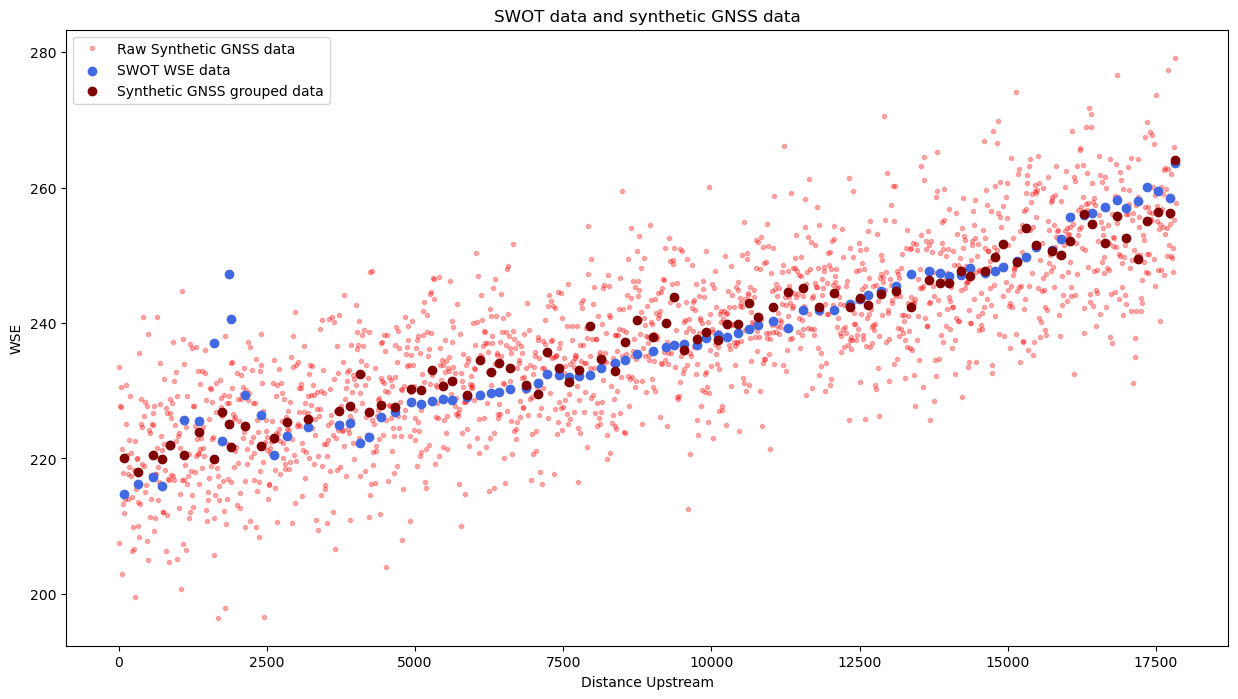

In [16]:
fig = plt.figure(figsize=(15, 8))
ax = fig.add_subplot(111)
ax.plot(dist_downstream, y, 'ro', zorder=1, markersize=3, alpha = .3, label='Raw Synthetic GNSS data')
ax.scatter(grouped_dist['Distance Downstream'], grouped_dist['WSE_SWOT'], color = 'royalblue', zorder=2, label='SWOT WSE data')
ax.scatter(grouped_dist['Distance Downstream'], grouped_dist['GNSS'], color = 'maroon', zorder=3, label='Synthetic GNSS grouped data')

ax.legend()
ax.set_title('SWOT data and synthetic GNSS data')
ax.set_xlabel('Distance Upstream')
ax.set_ylabel('WSE')


Here we will be doing an analysis to compare our 'GNSS' data, and the SWOT satellite data

Text(0, 0.5, 'SWOT WSE')

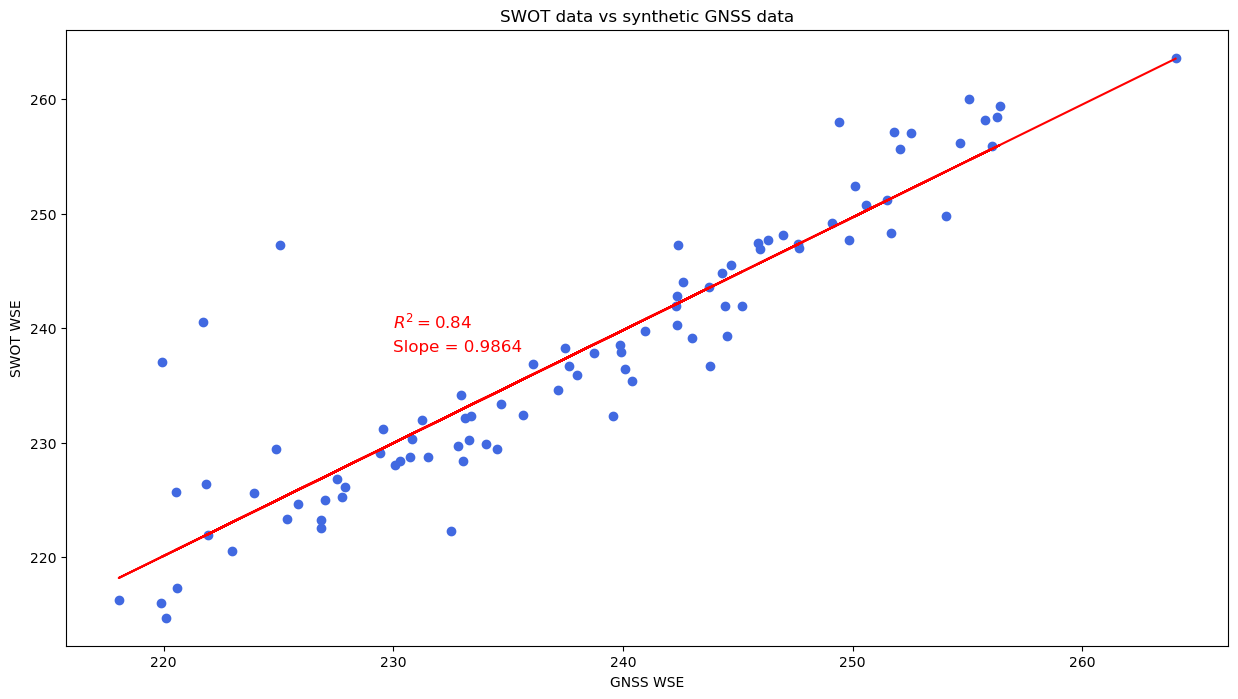

In [17]:
#The graph above shows that we now have a decent synthetic GNSS dataset to compare to our SWOT satellite data.
#Next lets plot our GNSS data against our SWOT data, but with a line of best fit and an r2 value.

SWOT_vs_GNSS = stats.linregress(grouped_dist['GNSS'], grouped_dist['WSE_SWOT'])
r_squared = SWOT_vs_GNSS.rvalue ** 2

#Now lets plot our data against eachother with the SWOT data on the y axis and the GNSS data on the x

fig = plt.figure(figsize=(15, 8))
ax = fig.add_subplot(111)

ax.scatter(grouped_dist['GNSS'], grouped_dist['WSE_SWOT'], color = 'royalblue', zorder=1)
ax.plot(grouped_dist['GNSS'], SWOT_vs_GNSS[1] + SWOT_vs_GNSS[0] * grouped_dist['GNSS'], 'r-')
ax.text(230, 240, f'$R^2 = {r_squared:.2f}$', fontsize=12, color = 'red')
ax.text(230, 238, f'Slope = {SWOT_vs_GNSS.slope:.4f}', fontsize=12, color = 'red')


ax.set_title('SWOT data vs synthetic GNSS data')
ax.set_xlabel('GNSS WSE')
ax.set_ylabel('SWOT WSE')

# Challenge #3:

Refering to the 2 plots above:

Explain in detail, what we did in this synthetic data creation/analysis in terms of:

    1. Where the GNSS raw data came from and how it was created
    2. Where the synthetic GNSS grouped data came from, and how it might be useful in an analysis
    3. How we got the raster WSE data into the plots above.
    4. How the GNSS grouped data and the SWOT WSE data are similar, but not exactly the same and,
    5. Why the slope of the plot above is close to 1, but not exactly 1. 

    your answer here:
    
    The GNSS raw data came from the pixel WSEs of the SWOT raster. To generate them we found a SWORD reach that intersects many of the SWOT pixels. We then turned the linetype into 1000s of points (similar to how gnss data is collected). Then we found the nearest WSE pixel value to each point. Then we grouped by matching WSE values (there are many points within a single pixel) to get our SWOT WSE points. We drew a line of best fit through these points, then we added random noise to the 1000s of points centered around that line of best fit to get our GNSS raw data. Then because everything is stored neatly in a dataframe, we can group again by our matching WSE points to get our grouped GNSS data points.
    
    The reason they are similar is because we added random noise based off a line of best fit through the SWOT data points. This is the same reason that the slope of the plot is close to 1 and not exactly 1, because we based all the points off a line of best fit for the SWOT points and not the SWOT points themselves.
    

# Challenge #4:

In the code cell below, perform another analysis that is different from the one above that will provide insight to how well the GNSS data and the SWOT data compare. Remember there is over 1,000 points of raw GNSS data that we condensed to match the number of pixels of WSE from SWOT, so we could do statistics on those points, or you can do whatever it is that you want. The world is your oyster.

In [1]:
# Your code here

#Basically anything goes here...
